In [1]:
!pip install wfdb --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.9 MB/s eta 0:00:00


# preprocessing

In [2]:
import wfdb
from scipy.signal import butter, filtfilt
import numpy as np
from scipy.signal import resample
from re import S
import os

In [3]:
def bandpass_filter(signal, fs=250, lowcut=0.5,  highcut=15.0,  order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)
    
def smooth_signal(data, window_size=5):
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(data, window, mode='same')
    return smoothed
def normalize_signal(data):
    return (data - np.mean(data)) / np.std(data)

In [4]:
from scipy.signal import resample

def resample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    resampled_signal = resample(signal, num_samples)
    return resampled_signal
def adjust_annotations(samples, original_fs, target_fs):
    scale = target_fs / original_fs
    if isinstance(samples, (list, np.ndarray)):
        return (np.array(samples) * scale).astype(int)
    else:
        return int(samples * scale)

# prediction functions

In [5]:
def predict_full_ecg(signal, model, fs=250, window_size=240):
    model.eval()
    signal = signal[:len(signal) - (len(signal) % window_size)]  # crop to multiple of window_size
    signal = normalize_signal(smooth_signal(bandpass_filter(signal, fs=fs)))
    if fs != 250:
        signal = resample_signal(signal, original_fs=fs, target_fs=250)
        fs = fs
    signal = signal.reshape(1, 1, -1)  # (1, 1, L)

    segments = []
    predictions = []

    for i in range(0, signal.shape[2] - window_size + 1, window_size):
        window = signal[:, :, i:i+window_size]
        segments.append(window)

    with torch.no_grad():
        for window in segments:
            window = torch.tensor(window, dtype=torch.float32).to(device)
            output = model(window)  # (1, C, L)
            pred = torch.argmax(output, dim=1).cpu().numpy()[0]  # (L,)
            predictions.append(pred)

    full_prediction = np.concatenate(predictions)
    return full_prediction, segments, predictions

In [6]:
def get_wave_boundaries(predicted_labels):
    wave_types = {1: 'P', 2: 'QRS', 3: 'T'}
    wave_boundaries = {k: [] for k in wave_types.values()}

    current_class = None
    start = None

    for i, label in enumerate(predicted_labels):
        if label in wave_types:
            if current_class is None:
                current_class = label
                start = i
            elif label != current_class:
                wave_boundaries[wave_types[current_class]].append((start, i-1))
                current_class = label
                start = i
        else:

            if current_class is not None:
                wave_boundaries[wave_types[current_class]].append((start, i-1))
                current_class = None
                start = None

    # Handle last segment
    if current_class is not None:
        wave_boundaries[wave_types[current_class]].append((start, len(predicted_labels)-1))

    return wave_boundaries

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_boundaries(signal, boundaries, signal_name, model_name, fs=250, zoom=(0, None)):
    time = np.arange(len(signal)) / fs  # Convert indices to time (seconds)

    plt.figure(figsize=(18, 6))
    plt.plot(time, signal, color='black', label='ECG Signal', linewidth=1)

    wave_colors = {'P': 'blue', 'QRS': 'red', 'T': 'green'}
    added_labels = set()

    # Convert zoom limits to sample indices
    zoom_start_idx = int(zoom[0] * fs)
    zoom_end_idx = int(zoom[1] * fs) if zoom[1] is not None else len(signal)

    for wave_type, regions in boundaries.items():
        for start, end in regions:
            # Only plot if within zoom range
            if start >= zoom_start_idx and end <= zoom_end_idx:
                label = f'Predicted {wave_type}' if wave_type not in added_labels else None
                plt.fill_between(
                    time[start:end],
                    -1, 1,
                    color=wave_colors.get(wave_type, 'gray'),
                    alpha=0.3,
                    label=label
                )
                added_labels.add(wave_type)

    plt.legend(loc='upper right')
    plt.title(f"signal: {signal_name}, model: {model_name}", fontsize=16)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.tight_layout()

    # Apply zoom
    plt.xlim(zoom[0], zoom[1] if zoom[1] is not None else time[-1])

    plt.show()

# Load model

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualConvBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, dilation=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3,
                              padding=dilation, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3,
                               padding=dilation, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        return F.relu(x)

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv1d(F_g, F_int, kernel_size=1),
            nn.BatchNorm1d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv1d(F_l, F_int, kernel_size=1),
            nn.BatchNorm1d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv1d(F_int, 1, kernel_size=1),
            nn.BatchNorm1d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class UNet1D_Enhanced(nn.Module):
    def __init__(self, in_channels=1, n_classes=4, base_filters=64):
        super().__init__()

        # Encoder with residual blocks and multi-scale context
        self.enc1 = ResidualConvBlock1D(in_channels, base_filters)
        self.pool1 = nn.MaxPool1d(2)

        self.enc2 = ResidualConvBlock1D(base_filters, base_filters*2)
        self.pool2 = nn.MaxPool1d(2)

        self.enc3 = ResidualConvBlock1D(base_filters*2, base_filters*4)
        self.pool3 = nn.MaxPool1d(2)

        self.enc4 = ResidualConvBlock1D(base_filters*4, base_filters*8)
        self.pool4 = nn.MaxPool1d(2)

        # Bottleneck with dilated convolution
        self.bottleneck = nn.Sequential(
            ResidualConvBlock1D(base_filters*8, base_filters*16, dilation=2),
            ResidualConvBlock1D(base_filters*16, base_filters*16, dilation=4)
        )

        # Decoder with attention gates
        self.upconv4 = nn.ConvTranspose1d(base_filters*16, base_filters*8, kernel_size=2, stride=2)
        self.att4 = AttentionBlock(base_filters*8, base_filters*8, base_filters//2)
        self.dec4 = ResidualConvBlock1D(base_filters*16, base_filters*8)

        self.upconv3 = nn.ConvTranspose1d(base_filters*8, base_filters*4, kernel_size=2, stride=2)
        self.att3 = AttentionBlock(base_filters*4, base_filters*4, base_filters//4)
        self.dec3 = ResidualConvBlock1D(base_filters*8, base_filters*4)

        self.upconv2 = nn.ConvTranspose1d(base_filters*4, base_filters*2, kernel_size=2, stride=2)
        self.att2 = AttentionBlock(base_filters*2, base_filters*2, base_filters//8)
        self.dec2 = ResidualConvBlock1D(base_filters*4, base_filters*2)

        self.upconv1 = nn.ConvTranspose1d(base_filters*2, base_filters, kernel_size=2, stride=2)
        self.att1 = AttentionBlock(base_filters, base_filters, base_filters//16)
        self.dec1 = ResidualConvBlock1D(base_filters*2, base_filters)

        # Output with multi-scale feature fusion
        self.final_conv = nn.Sequential(
            nn.Conv1d(base_filters, base_filters//2, kernel_size=3, padding=1),
            nn.BatchNorm1d(base_filters//2),
            nn.ReLU(),
            nn.Conv1d(base_filters//2, n_classes, kernel_size=1)
        )

        # Boundary refinement
        self.boundary_refine = nn.Conv1d(n_classes, n_classes, kernel_size=5, padding=2)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # Bottleneck
        b = self.bottleneck(self.pool4(e4))

        # Decoder with attention
        d4 = self.upconv4(b)
        e4 = self.att4(d4, center_crop(e4, d4.shape[-1]))
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = self.upconv3(d4)
        e3 = self.att3(d3, center_crop(e3, d3.shape[-1]))
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.upconv2(d3)
        e2 = self.att2(d2, center_crop(e2, d2.shape[-1]))
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.upconv1(d2)
        e1 = self.att1(d1, center_crop(e1, d1.shape[-1]))
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        # Output
        out = self.final_conv(d1)

        # Boundary refinement
        out = out + self.boundary_refine(out)  # Residual connection

        return out


def center_crop(enc_feat, target_size):
    _, _, L = enc_feat.size()
    diff = L - target_size
    if diff == 0:
        return enc_feat
    elif diff < 0:
        raise ValueError("Encoder feature shorter than target")
    start = diff // 2
    end = start + target_size
    return enc_feat[:, :, start:end]

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize model
model_deep = UNet1D_Enhanced(n_classes=4).to(device)
model_deep.load_state_dict(torch.load("/kaggle/input/unet-model-for-ecg-mask-detection/pytorch/default/1/updated_unet1d_ecg_qrs.pth", map_location=device))
model_deep.to(device)
model_deep.eval()

UNet1D_Enhanced(
  (enc1): ResidualConvBlock1D(
    (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): ResidualConvBlock1D(
    (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

# predection

In [10]:
def div_signal(signal, window_size = 240):
    segments = []
    signal = signal.reshape(1, 1, -1)  # (1, 1, L)
    for i in range(0, signal.shape[2] - window_size + 1, window_size):
            window = signal[:, :, i:i+window_size]
            segments.append(window)
    signal = np.concatenate(segments, axis=2)
    signal = signal.reshape(-1)
    return signal

In [11]:
base_path = '/kaggle/input/qtdb-ludb/physionet.org/files/mitdb/1.0.0/'
rd_name = '113'
record_name = base_path+rd_name

record = wfdb.rdrecord(record_name)
signal = record.p_signal[:, 0]
fs = record.fs
signal = signal[int(10*fs):int(25*fs)]


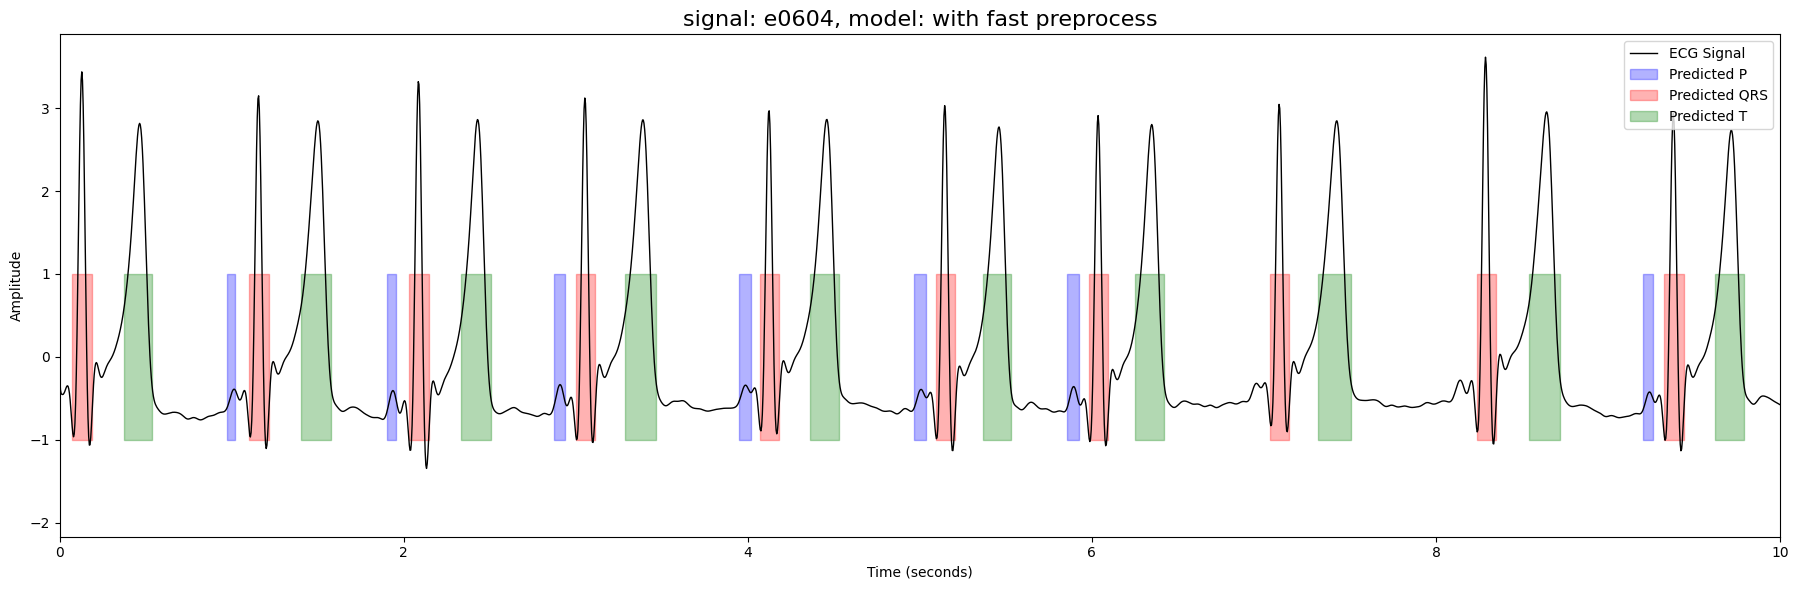

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------


In [12]:
mask,segments,_ = predict_full_ecg(signal, model_deep, fs=fs)
signal = np.concatenate(segments, axis=2)
signal = signal.reshape(-1)
boundaries_fast = get_wave_boundaries(mask)
visualize_boundaries(signal, boundaries_fast,signal_name="e0604", model_name="with fast preprocess", fs=250, zoom=(0, 10))

print(120*"-")
print(120*"-")

# post processing

## remove_uncomplete_first_last_wave

this function removing the first and last part of mask if it was QRS , P or T , cause probably it's not complete 

In [13]:
import numpy as np

def remove_uncomplete_first_last_wave(predicted):
    start = predicted[0]
    end = predicted[-1]
    if start != 0:
      i=0
      while i < len(predicted) and predicted[i]==start:
        i+=1
      predicted[:i]=0
    if end != 0:
      i=len(predicted)-1
      while i > -1 and predicted[i]==end:
        i-=1
      predicted[i+1:]=0

    return predicted

predicted = np.array([1,1,1,2,2, 0, 0, 1, 0, 2, 2, 3, 0, 0,0,2,1,3, 3])
print(len(predicted))

predicted = remove_uncomplete_first_last_wave(predicted)
print(predicted)

(len(predicted))

19
[0 0 0 2 2 0 0 1 0 2 2 3 0 0 0 2 1 0 0]


19

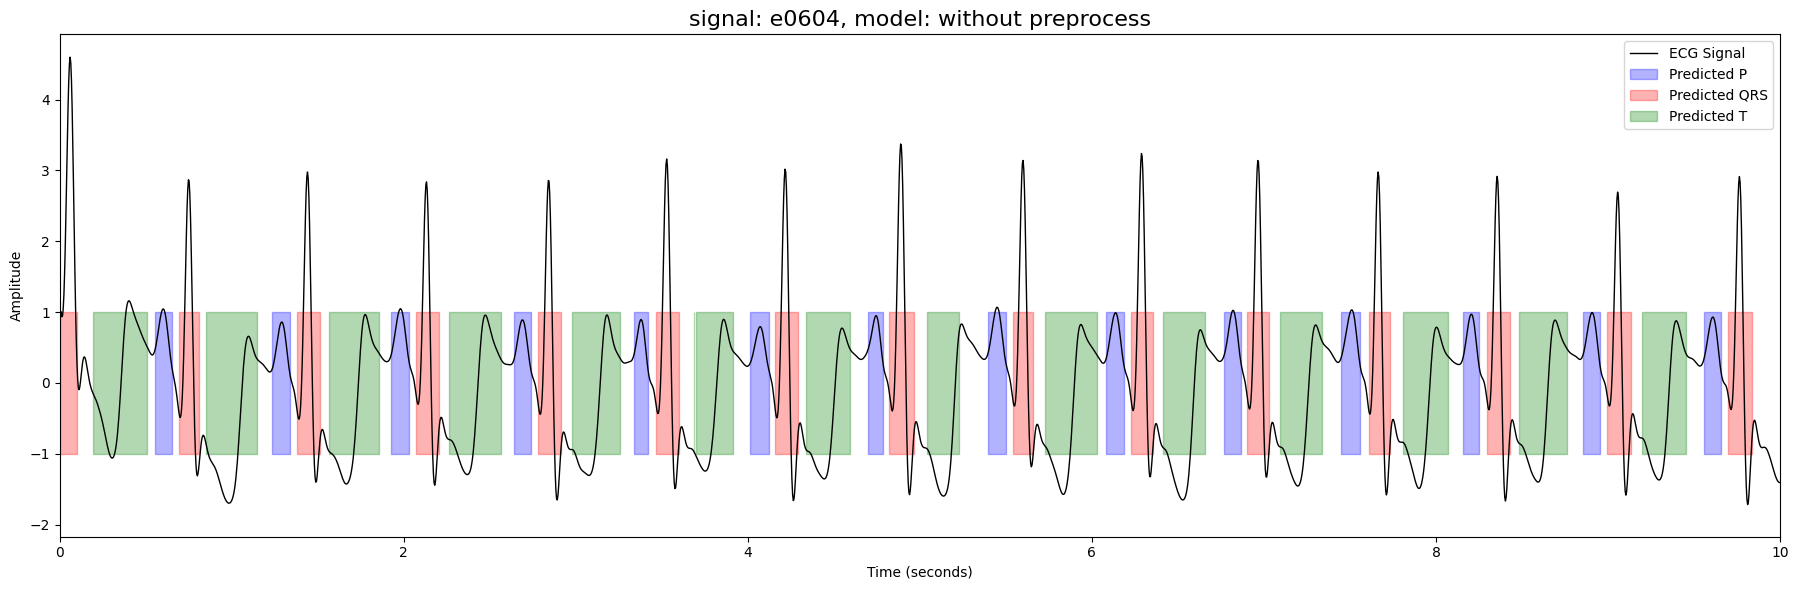

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------


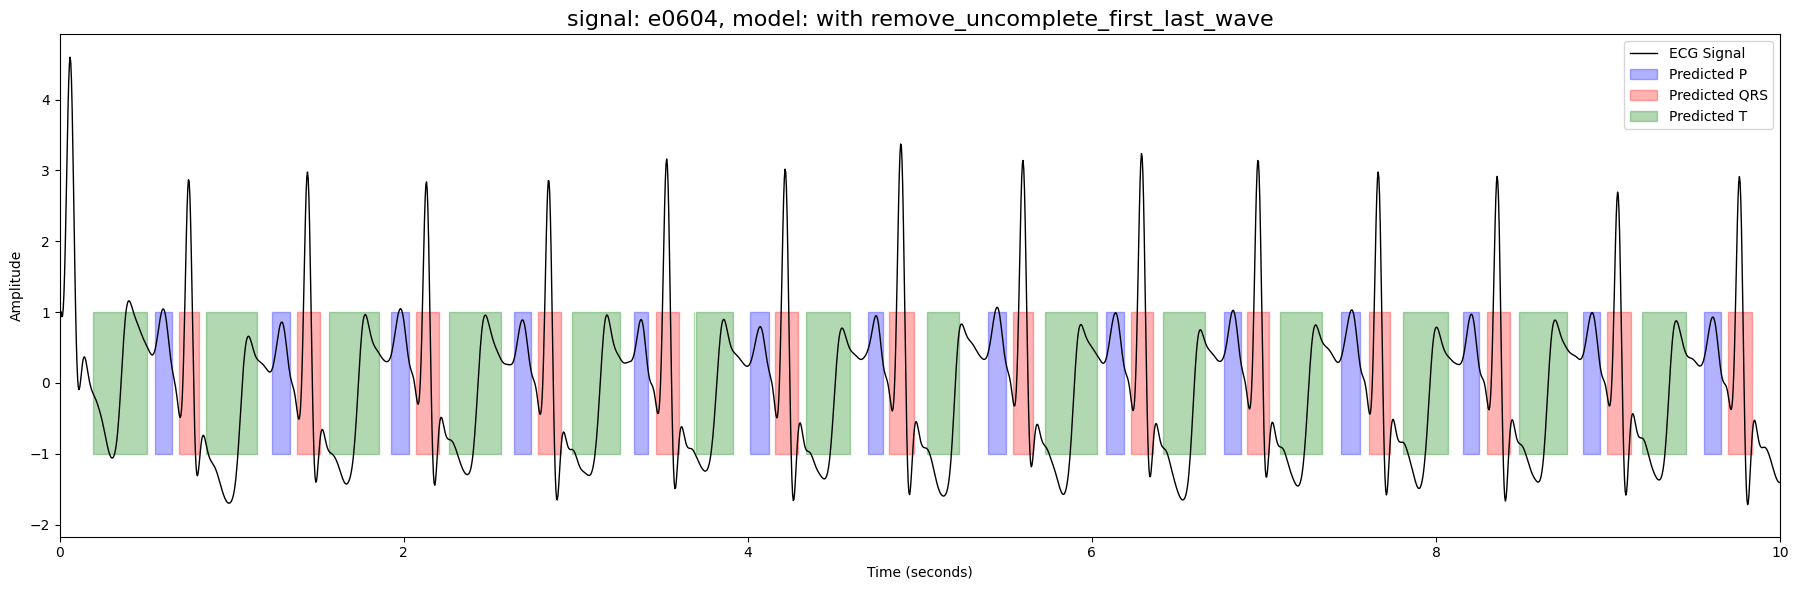

In [14]:
base_path = '/kaggle/input/qtdb-ludb/physionet.org/files/mitdb/1.0.0/'
rd_name = '112'
record_name = base_path+rd_name

record = wfdb.rdrecord(record_name)
signal = record.p_signal[:, 0]
fs = record.fs
signal = signal[int(10*fs):int(25*fs)]
mask,segments,_ = predict_full_ecg(signal, model_deep, fs=fs)
signal = np.concatenate(segments, axis=2)
signal = signal.reshape(-1)
boundaries_fast = get_wave_boundaries(mask)
visualize_boundaries(signal, boundaries_fast,signal_name="e0604", model_name="without preprocess", fs=250, zoom=(0, 10))

print(120*"-")
print(120*"-")

mask = remove_uncomplete_first_last_wave(mask)
boundaries_fast = get_wave_boundaries(mask)
visualize_boundaries(signal, boundaries_fast,signal_name="e0604", model_name="with remove_uncomplete_first_last_wave", fs=250, zoom=(0, 10))


## merge_close_waves

basicly merging close masks 

In [15]:
import numpy as np

def merge_close_waves(predicted, max_gap=10):
  predicted = predicted.copy()
  for target_class in [1,2,3]:
    indices = np.where(predicted == target_class)[0]

    if len(indices) < 2:
        return predicted  

    for i in range(len(indices) - 1):
        current = indices[i]
        next_ = indices[i + 1]
        if 0 < next_ - current - 1 < max_gap:
            predicted[current:next_ + 1] = target_class



  return predicted
predicted = np.array([0, 1, 1, 0, 1, 2, 2, 0, 0, 1, 2, 1, 1, 0, 0, 2, 2, 0, 3, 3, 3, 3, 3, 0])
print(len(predicted))

predicted = merge_close_waves(predicted)
print(predicted)
print(len(predicted))



24
[0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 2 0 3 3 3 3 3 0]
24


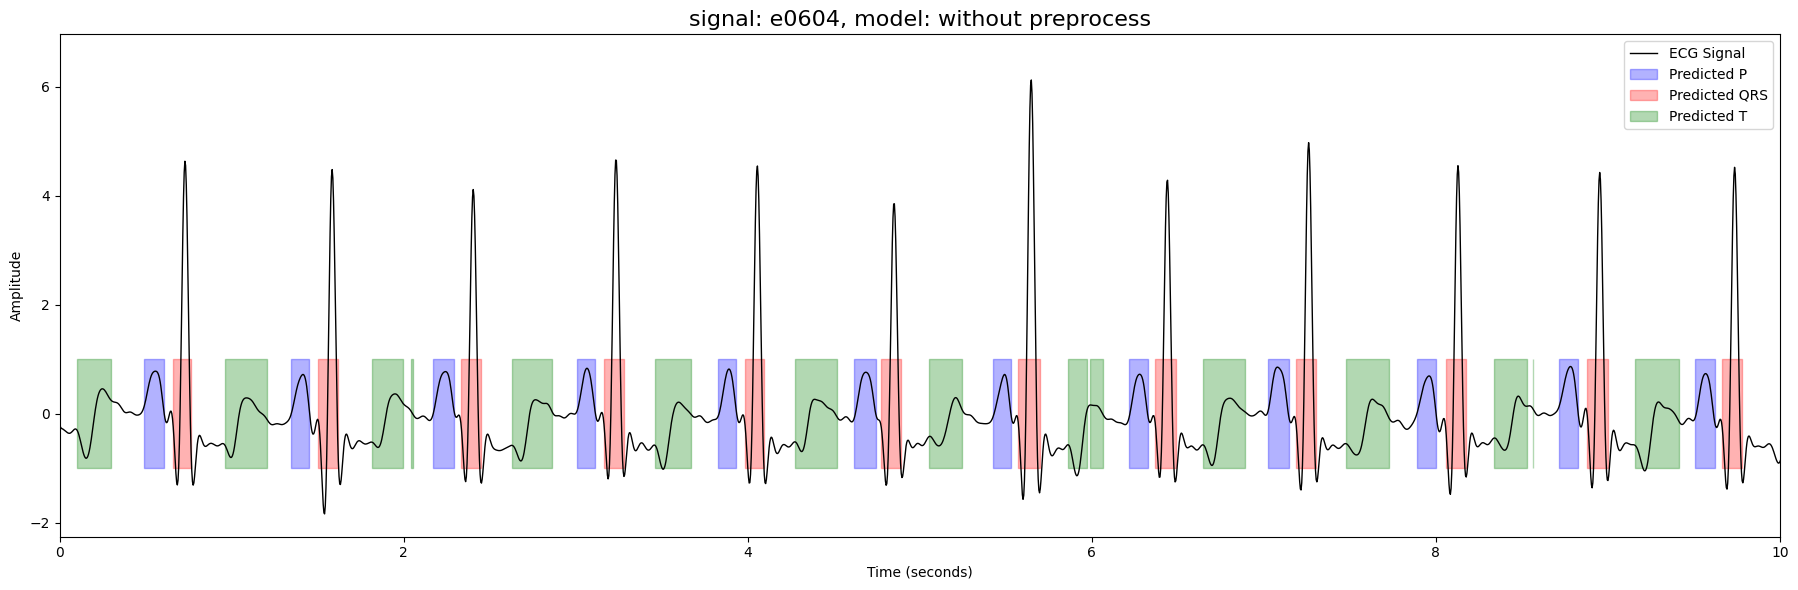

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------


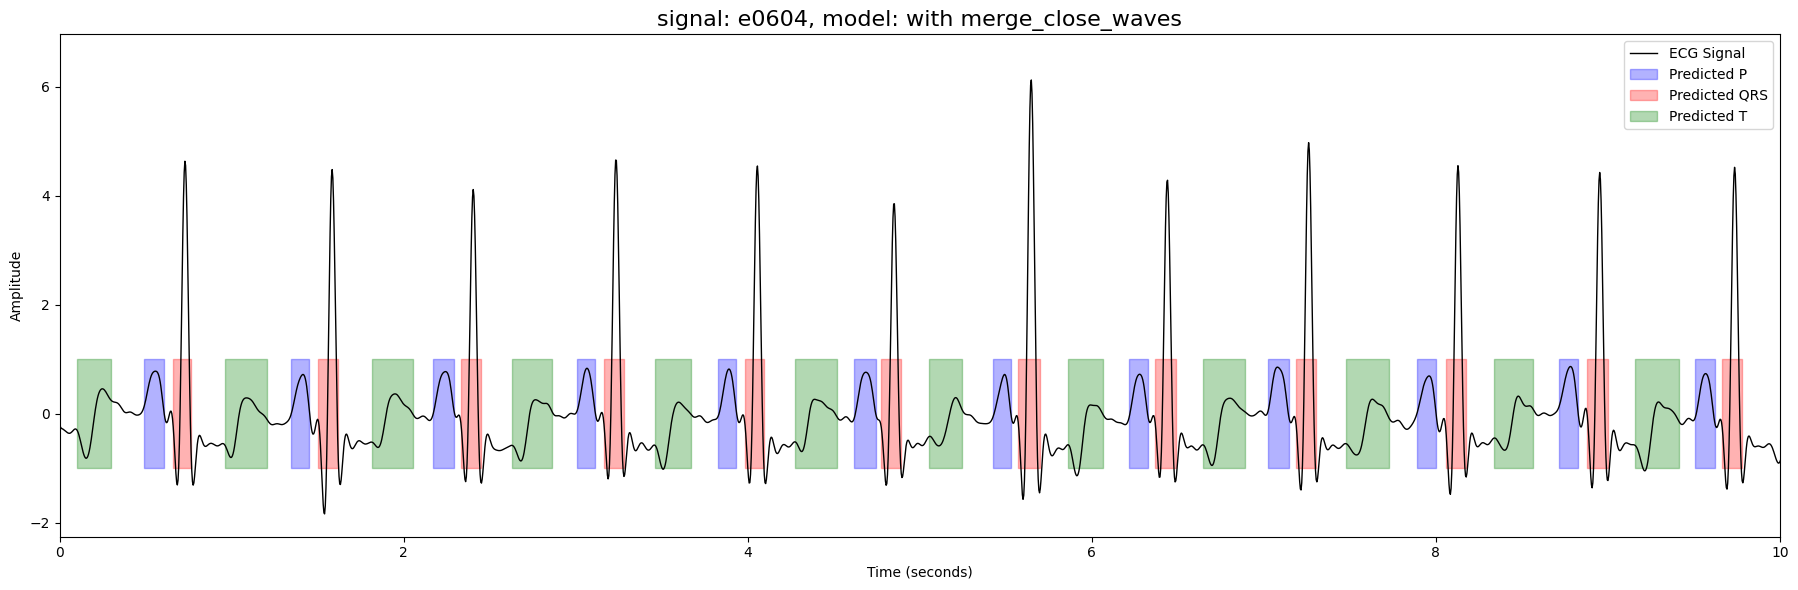

In [16]:
base_path = '/kaggle/input/qtdb-ludb/physionet.org/files/mitdb/1.0.0/'
rd_name = '100'
record_name = base_path+rd_name

record = wfdb.rdrecord(record_name)
signal = record.p_signal[:, 0]
fs = record.fs
signal = signal[int(10*fs):int(25*fs)]
mask,segments,_ = predict_full_ecg(signal, model_deep, fs=fs)
signal = np.concatenate(segments, axis=2)
signal = signal.reshape(-1)
boundaries_fast = get_wave_boundaries(mask)
visualize_boundaries(signal, boundaries_fast,signal_name="e0604", model_name="without preprocess", fs=250, zoom=(0, 10))

print(120*"-")
print(120*"-")

mask = merge_close_waves(mask)
boundaries_fast = get_wave_boundaries(mask)
visualize_boundaries(signal, boundaries_fast,signal_name="e0604", model_name="with merge_close_waves", fs=250, zoom=(0, 10))

## remove_irrelevant_waves

Remove waves before the first P and after the last T that are not relevant.

In [17]:
def remove_irrelevant_waves(predicted,start_search=2,end_search=5):
    start=0
    # Find the first P that has a QRS after it
    if 1 in predicted[:start_search*250] :
      for i in range(len(predicted)-1):
          start = i

          if predicted[i] == 1:
              start = i
              
              while i < len(predicted)-1 and predicted[i] == 1:
                i += 1
              # if it's not 0 or 2 break
              if predicted[i] == 3:
                continue
              # skip background if it exist
              if predicted[i] == 0:
                while i < len(predicted)-1 and predicted[i] == 0:
                  i += 1
              # if it's not qrs continue to next p
              if predicted[i] != 2:
                continue
              else:
                break
      predicted[:start] = 0


    # remove after last T
    if 3 in predicted[-end_search*250:]:
      
      end = predicted[-1]
      for i in range((len(predicted) - 1), -1, -1):
          end = i

          if predicted[i] == 3:
              end = i
              while i > 0 and predicted[i] == 3:
                i -= 1
              # if it's not 0 or 2 break
              if predicted[i] == 1:
                continue
              # skip background if it exist
              if predicted[i] == 0:
                while i > 0 and predicted[i] == 0:
                  i -= 1
              # if it's not qrs continue to next t
              if predicted[i] != 2:
                continue
              else:
                break
      predicted[end+1:] = 0

    return (predicted)




predicted = np.array([0, 1, 1, 0,0,3,2,0,0,1,1,0,2,2,0,0,1,0,1,1,0,0 ,2, 2,0,3,3,3,3 ,3, 0, 3, 3, 0]) 
print(len(predicted))

cleaned_predicted = remove_irrelevant_waves(predicted)
print(cleaned_predicted)
print(len(predicted))

34
[0 0 0 0 0 0 0 0 0 1 1 0 2 2 0 0 1 0 1 1 0 0 2 2 0 3 3 3 3 3 0 0 0 0]
34


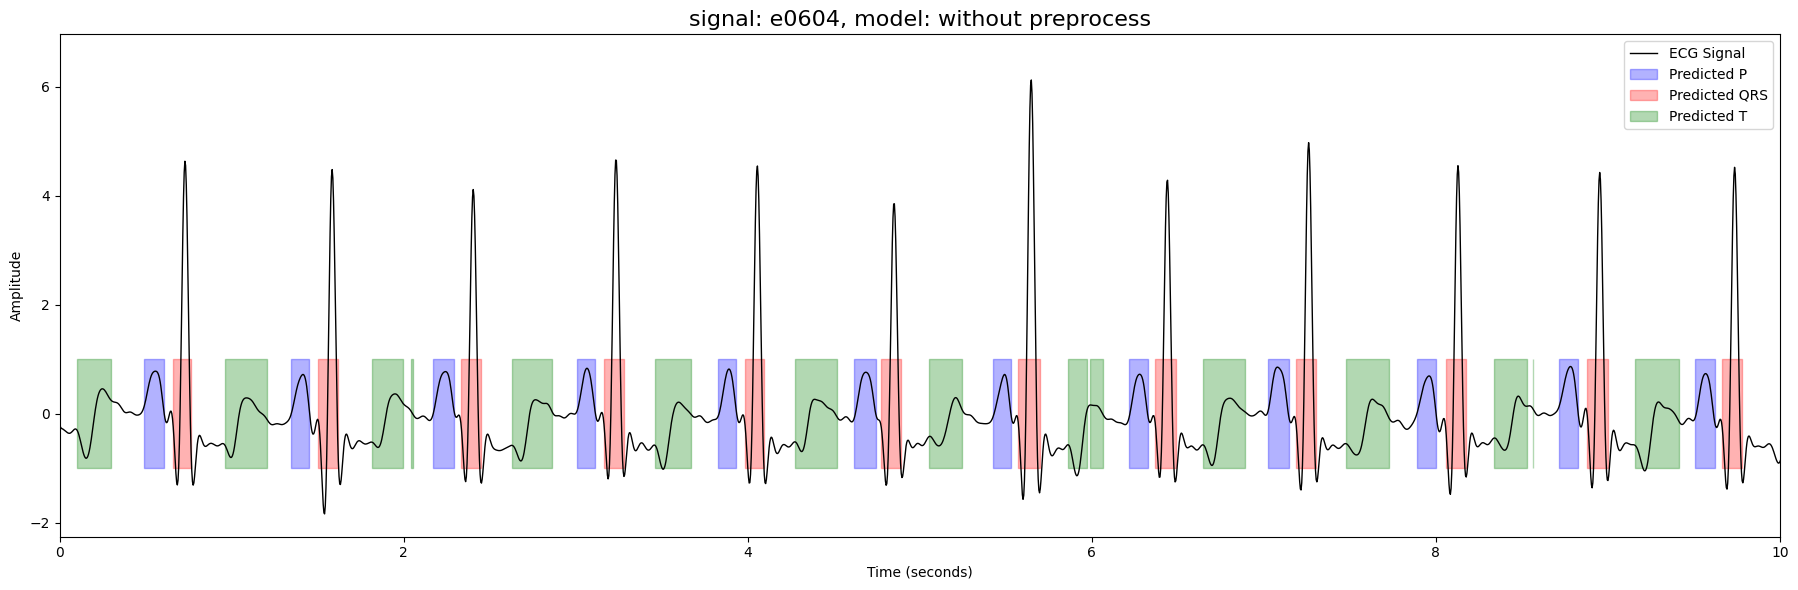

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------


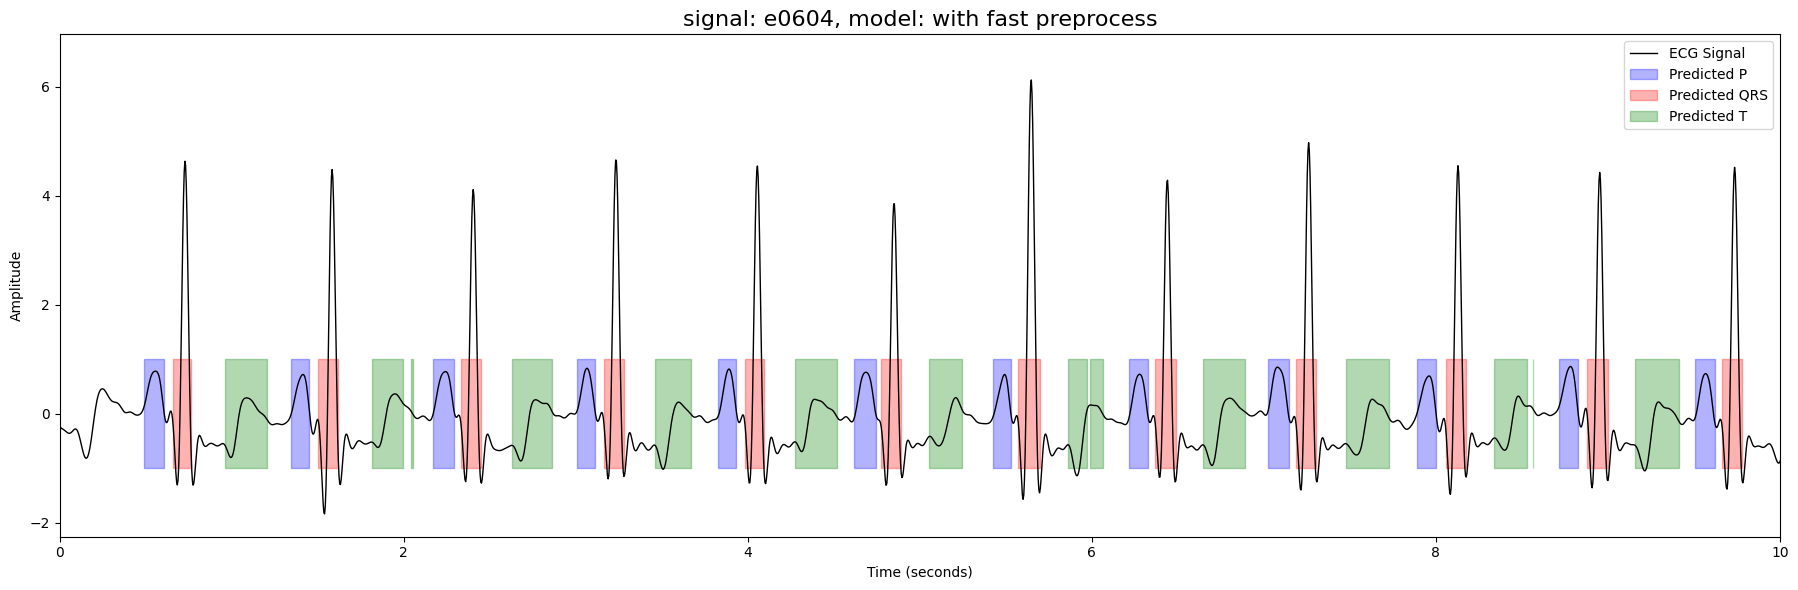

In [18]:
base_path = '/kaggle/input/qtdb-ludb/physionet.org/files/mitdb/1.0.0/'
rd_name = '100'
record_name = base_path+rd_name

record = wfdb.rdrecord(record_name)
signal = record.p_signal[:, 0]
fs = record.fs
signal = signal[int(10*fs):int(25*fs)]
mask,segments,_ = predict_full_ecg(signal, model_deep, fs=fs)
signal = np.concatenate(segments, axis=2)
signal = signal.reshape(-1)
boundaries_fast = get_wave_boundaries(mask)
visualize_boundaries(signal, boundaries_fast,signal_name="e0604", model_name="without preprocess", fs=250, zoom=(0, 10))

print(120*"-")
print(120*"-")

mask = remove_irrelevant_waves(mask)
boundaries_fast = get_wave_boundaries(mask)
visualize_boundaries(signal, boundaries_fast,signal_name="e0604", model_name="with fast preprocess", fs=250, zoom=(0, 10))

## check_repeated_waves

Merge or remove close-together same-class segments if separated only by background.

In [19]:
def check_repeated_waves(predicted):
    cleaned = predicted.copy()
    for target_class in [1,2,3]:
      segments = []
      in_segment = False
      start = 0

      # Step 1: Collect all segments of the target class
      for i, val in enumerate(predicted):
          if val == target_class and not in_segment:
              in_segment = True
              start = i
          elif val != target_class and in_segment:
              in_segment = False
              segments.append((start, i - 1))
      if in_segment:
          segments.append((start, len(predicted) - 1))

      # Step 2: Check for pairs of segments with only background (0) in between
      i = 0
      while i < len(segments) - 1:
          s1, e1 = segments[i]
          s2, e2 = segments[i + 1]
          between = cleaned[e1 + 1:s2]

          if np.all(between == 0):  # Only background between them
              len1 = e1 - s1 + 1
              len2 = e2 - s2 + 1

              # Remove the shorter one
              if len1 < len2:
                  cleaned[s1:e1 + 1] = 0
              else:
                  cleaned[s2:e2 + 1] = 0

              # Remove the deleted segment from the list
              segments.pop(i if len1 < len2 else i + 1)
          else:
              i += 1


    return cleaned

predicted = np.array([0, 1, 1,1, 0,1,1, 2, 2, 0, 0, 1, 0, 1, 1, 0, 0, 2, 2,0, 2, 2, 2,  0, 3, 3, 0, 3,3, 3, 0,])
print(len(predicted))
predicted = check_repeated_waves(predicted)
print(predicted)
print(len(predicted))

31
[0 1 1 1 0 0 0 2 2 0 0 0 0 1 1 0 0 0 0 0 2 2 2 0 0 0 0 3 3 3 0]
31


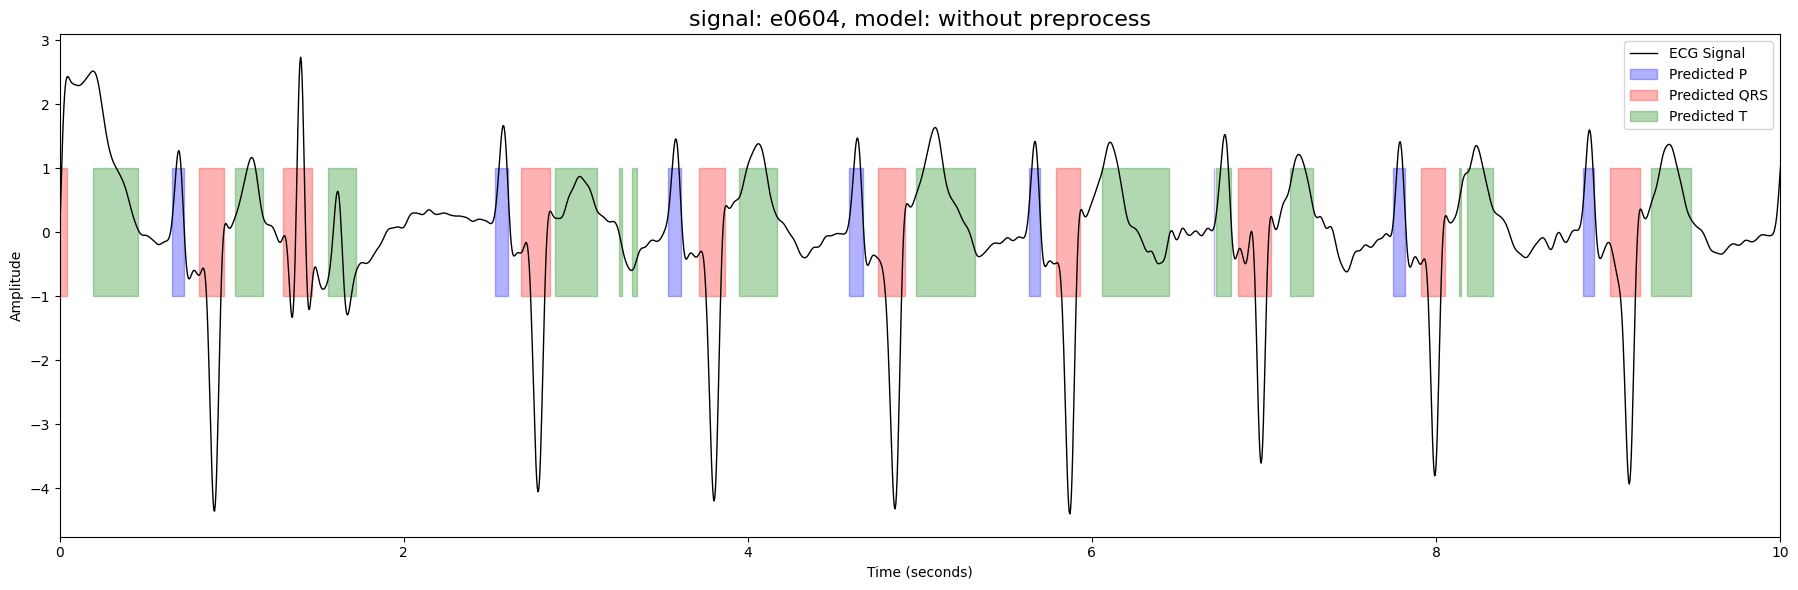

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------


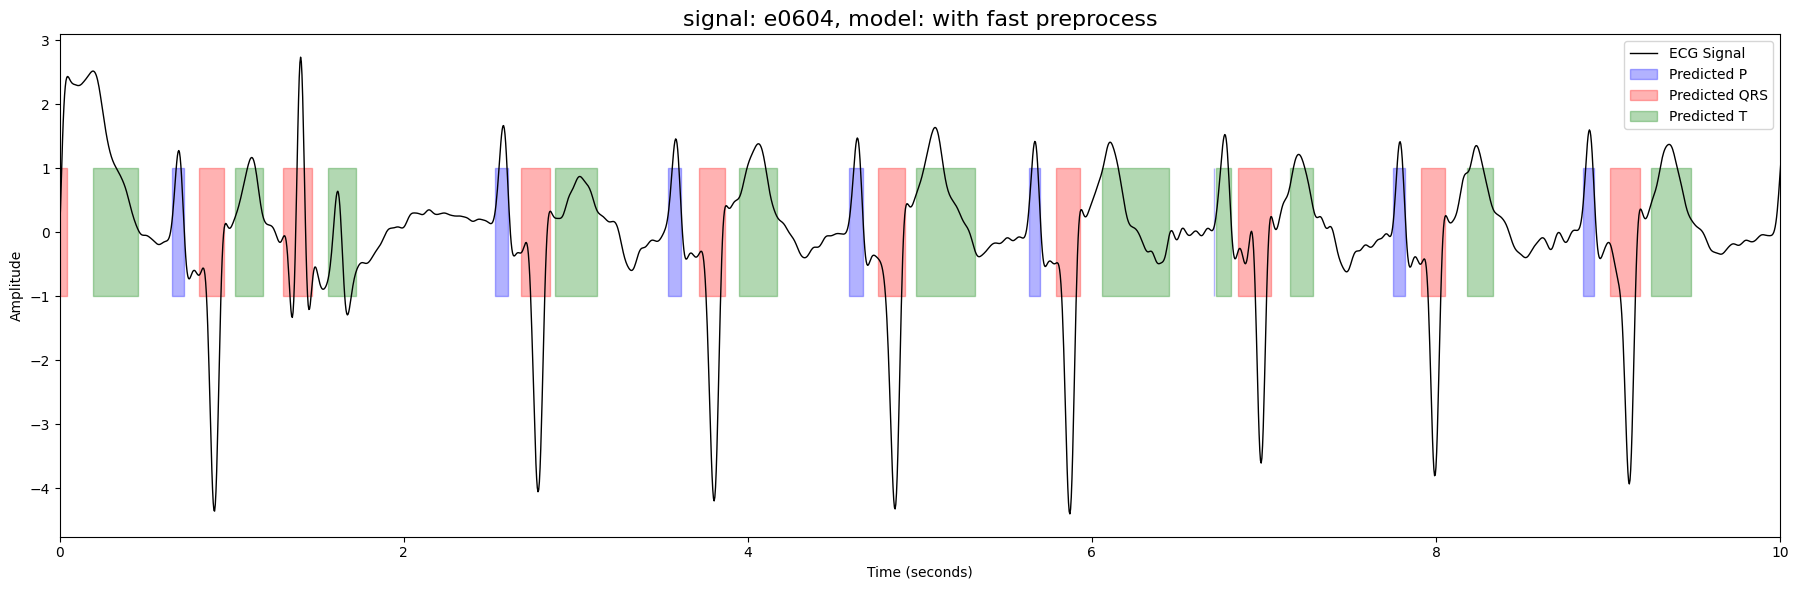

In [20]:
base_path = '/kaggle/input/qtdb-ludb/physionet.org/files/mitdb/1.0.0/'
rd_name = '108'
record_name = base_path+rd_name

record = wfdb.rdrecord(record_name)
signal = record.p_signal[:, 0]
fs = record.fs
signal = signal[int(10*fs):int(25*fs)]
mask,segments,_ = predict_full_ecg(signal, model_deep, fs=fs)
signal = np.concatenate(segments, axis=2)
signal = signal.reshape(-1)
boundaries_fast = get_wave_boundaries(mask)
visualize_boundaries(signal, boundaries_fast,signal_name="e0604", model_name="without preprocess", fs=250, zoom=(0, 10))

print(120*"-")
print(120*"-")

mask = check_repeated_waves(mask)
boundaries_fast = get_wave_boundaries(mask)
visualize_boundaries(signal, boundaries_fast,signal_name="e0604", model_name="with fast preprocess", fs=250, zoom=(0, 10))

## fix_P

fixing incomplete p waves by completing them

In [21]:
from scipy.signal import find_peaks
from tqdm import tqdm
def fix_before_P(signal,mask,p_start,p_end,slope_threshold=0.02):
  diff_signal = np.diff([signal[p_start],signal[p_start-5]])  # check around the Q point for slope change
  j = 0
  while True:
    while np.abs(diff_signal[-1]) >= slope_threshold and signal[p_start]>signal[p_start-1] and mask[p_start-1]==0:  # Continue until slope becomes small
        j+=1
        p_start -= 1
        mask[p_start] = 1  # mark as part of the QRS
        diff_signal = np.diff([signal[p_start],signal[p_start-5]])  # re-evaluate slope
    if mask[p_start-1]!=0:
      break
    if j == 0:

        slope_threshold -= 0.001
        #print("slope_threshold: ",slope_threshold)
        if slope_threshold < 0.005:
          break
    else:
        break
  #print ("fixed_before with peak:",j)
  return mask,p_start


def fix_P(signal, mask):
    p_mask = (mask == 1).astype(int)
    qrs_mask = (mask == 2).astype(int)

    transitions = np.diff(p_mask, prepend=0)
    p_starts = np.where(transitions == 1)[0]

    qrs_starts = np.where(np.diff(qrs_mask, prepend=0) == 1)[0]

    fixed_p_info = []

    for i in tqdm(range(len(p_starts)), desc="Processing P"):

        slope_threshold = 0.02  # arbitrary threshold for slope to be considered small
        p_start = p_starts[i]

        p_next = p_starts[i+1] if i < len(p_starts) - 1 else len(mask)
        p_indices = np.where((mask == 1) & (np.arange(len(mask)) >= p_start) & (np.arange(len(mask)) < p_next))[0]

        p_end = p_indices[-1] if  len(p_indices)>0 else p_start
        #print("p_start,p_end: ",p_start,p_end)
        # Get indices of current P segment
        if len(p_indices) < 3:
            continue

        p_wave = signal[p_indices]

        # Check for peak inside current P segment
        peaks, _ = find_peaks(p_wave, prominence=0.01)
        has_peak = len(peaks) > 0
        peak_index = p_indices[peaks[0]] if has_peak else None

        # If no peak, look after end of P segment
        post_p_peak_index = None
        if has_peak:
          #print("has peak")
          mask, p_start = fix_before_P(signal, mask,p_start,p_end)
          j=0
          #print(p_end)
          while (p_end + 1 < len(signal)) and signal[p_end] > signal[p_start] and mask[p_end + 1] == 0:
            j += 1
            p_end += 1
            mask[p_end] = 1
        if not has_peak:

            # Look ahead to the next QRS start
            next_qrs_start = qrs_starts[qrs_starts > p_end]
            next_qrs_start = next_qrs_start[0] if len(next_qrs_start) > 0 else len(signal)

            # Look AFTER the P segment
            post_range = np.arange(p_start,min(len(signal) ,p_end + 50,  next_qrs_start ))
            post_peaks = []
            if len(post_range) > 3:
                post_wave = signal[post_range]
                peaks, _ = find_peaks(post_wave, prominence=0.01)
                # Filter by mask == 0
                for p in peaks:
                    peak_idx = post_range[p]
                    # Check that the region from p_end to peak_idx is all mask == 0
                    if np.all(mask[p_end+1:peak_idx + 1] == 0):
                        post_peaks.append(peak_idx)


            # Look BEFORE the P segment
            pre_range = np.arange(max(0, p_start - 50), p_end)  # limit the look-back window to ~400ms
            pre_peaks = []
            if len(pre_range) > 3:
                pre_wave = signal[pre_range]
                peaks, _ = find_peaks(pre_wave, prominence=0.01)
                # Filter by mask == 0
                pre_peaks = [pre_range[p] for p in peaks if mask[pre_range[p]] == 0]
                for p in peaks:
                    peak_idx = pre_range[p]
                    # Check that the region from p_end to peak_idx is all mask == 0
                    if np.all(mask[peak_idx + 1:p_start] == 0):
                        pre_peaks.append(peak_idx)

            # Closest peak
            ## Combine both and choose closest properly
            closest_peak = None
            min_distance = float('inf')

            ## Compare post-peaks to p_end
            for peak in post_peaks:
                dist = abs(peak - p_end)
                if dist < min_distance:
                    min_distance = dist
                    closest_peak = peak

            ## Compare pre-peaks to p_start
            for peak in pre_peaks:
                dist = abs(peak - p_start)
                if dist < min_distance:
                    min_distance = dist
                    closest_peak = peak

            post_p_peak_index = closest_peak if closest_peak is not None else None

            peak = None
            if post_p_peak_index is not None:
              if post_p_peak_index < p_start:
                peak = "before"
              else:
                peak = "after"


            #print(peak)
            if peak == "after":
                mask, p_start = fix_before_P(signal, mask,p_start,p_end)
                j=0
                while (p_end + 1 < len(signal)) and signal[p_end] > signal[p_start] and mask[p_end + 1] == 0:
                  j += 1
                  p_end += 1
                  mask[p_end] = 1
            elif peak == "before":

                mask[post_p_peak_index-2:p_start] = 1
                p_start = post_p_peak_index-2
                mask, p_start = fix_before_P(signal, mask,p_start,p_end)


        fixed_p_info.append({
            'start': p_indices[0],
            'end': p_indices[-1],
            'has_peak': has_peak,
            'peak_index': peak_index,
            'post_p_peak_index': post_p_peak_index
        })
        #print (fixed_p_info)

    return mask

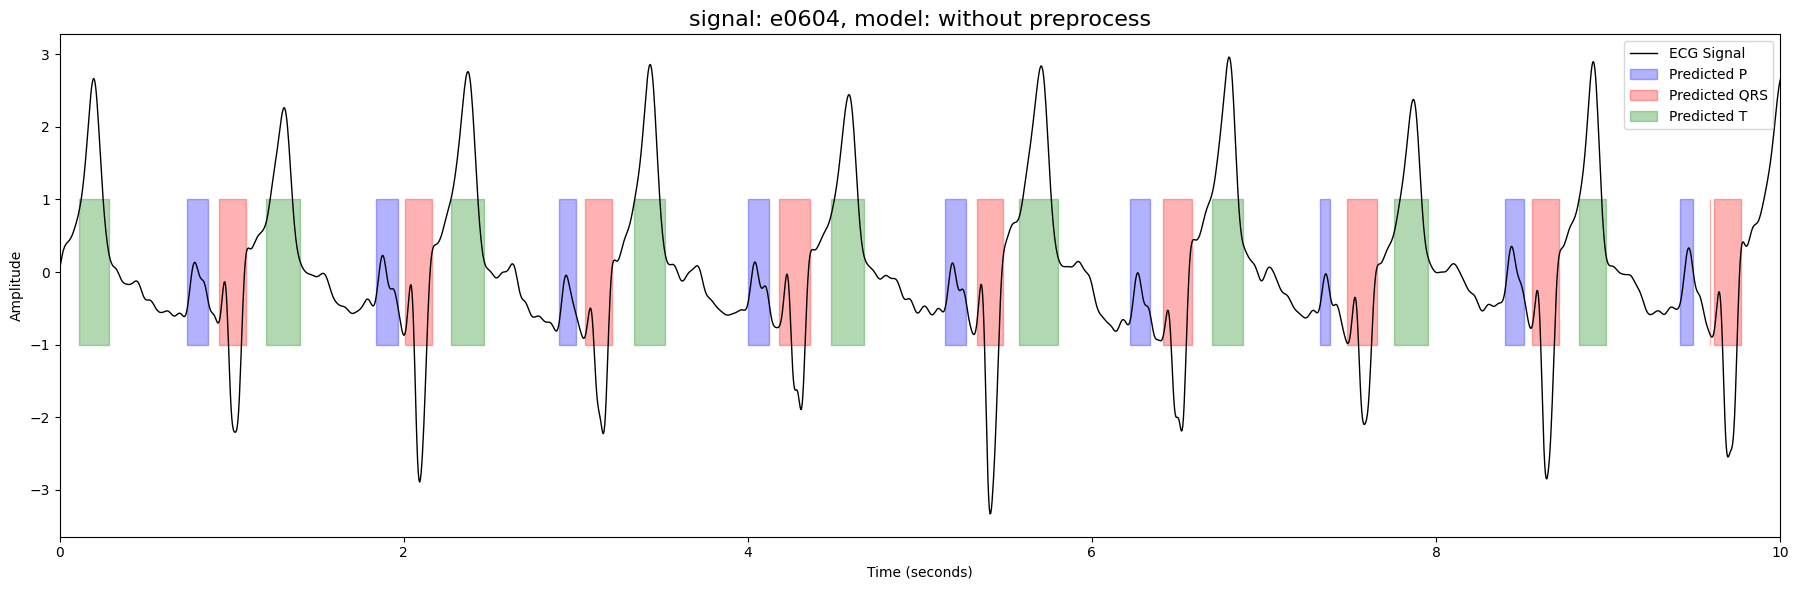

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------


Processing P: 100%|██████████| 13/13 [00:00<00:00, 4241.61it/s]


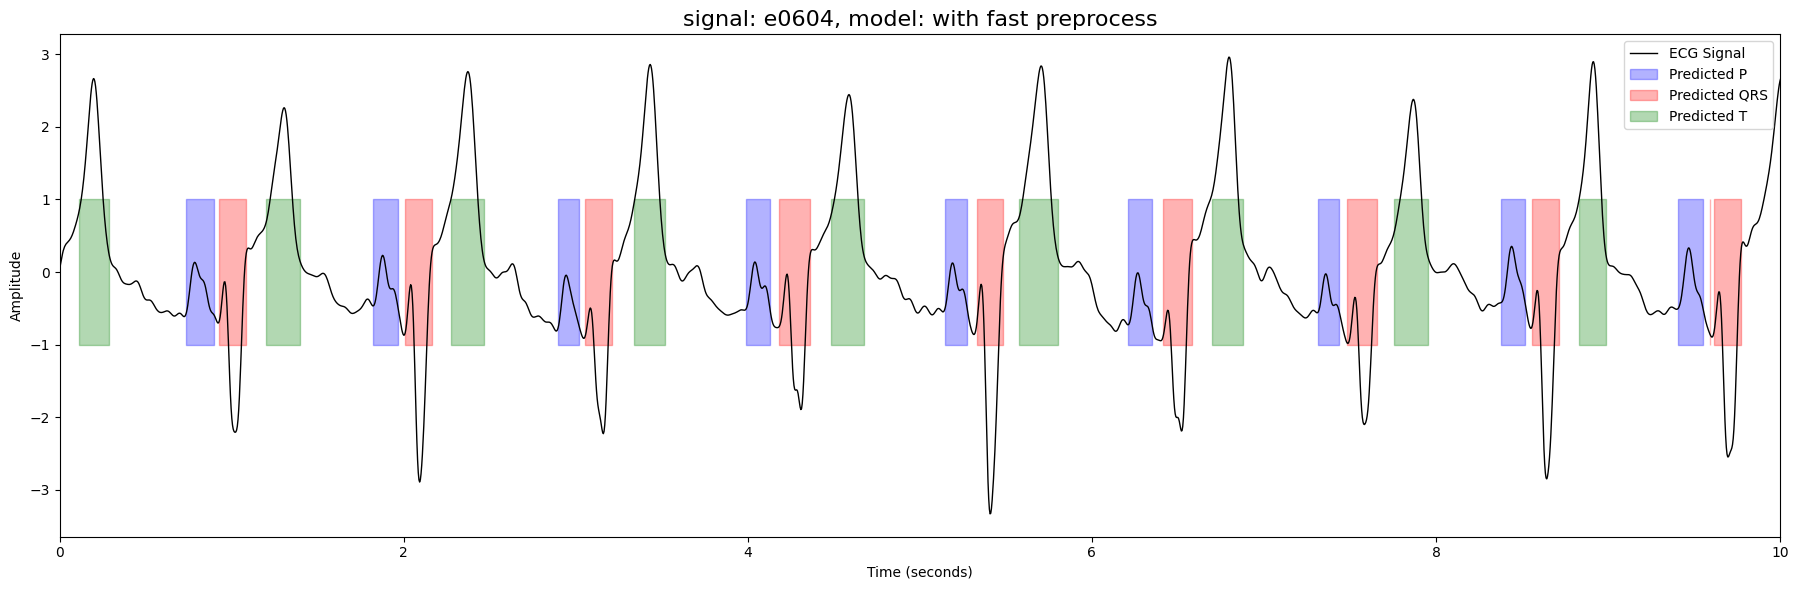

In [22]:
base_path = '/kaggle/input/qtdb-ludb/physionet.org/files/mitdb/1.0.0/'
rd_name = '114'
record_name = base_path+rd_name

record = wfdb.rdrecord(record_name)
signal = record.p_signal[:, 0]
fs = record.fs
signal = signal[int(10*fs):int(25*fs)]
mask,segments,_ = predict_full_ecg(signal, model_deep, fs=fs)
signal = np.concatenate(segments, axis=2)
signal = signal.reshape(-1)
boundaries_fast = get_wave_boundaries(mask)
visualize_boundaries(signal, boundaries_fast,signal_name="e0604", model_name="without preprocess", fs=250, zoom=(0, 10))

print(120*"-")
print(120*"-")

mask = fix_P(signal,mask)
boundaries_fast = get_wave_boundaries(mask)
visualize_boundaries(signal, boundaries_fast,signal_name="e0604", model_name="with fast preprocess", fs=250, zoom=(0, 10))

## fix QRS

In [23]:
def fast_fix_QRS(signal, mask, fs=250):
    # time = np.arange(len(signal)) / fs
    # indices = np.arange(len(mask))  # Precompute indices array

    # Precompute slopes for QRS start and end adjustments
    # slope_start = np.zeros_like(signal)
    # slope_start[3:] = signal[3:] - signal[:-3]  # slope[i] = signal[i] - signal[i-3]
    slope_end = np.zeros_like(signal)
    slope_end[:-5] = signal[:-5] - signal[5:]    # slope[i] = signal[i] - signal[i+5]

    # Identify QRS regions (mask == 2)
    qrs_mask = (mask == 2).astype(np.int8)
    transitions = np.diff(qrs_mask, prepend=0)
    qrs_starts = np.flatnonzero(transitions == 1)
    qrs_ends = np.flatnonzero(transitions == -1) - 1
    n = len(signal)

    if len(qrs_ends) < len(qrs_starts):
        qrs_ends = np.append(qrs_ends, n - 1)

    for i in tqdm(range(len(qrs_starts)), desc="Processing QRS"):
        qrs_start = qrs_starts[i]
        # next_qrs_start = qrs_starts[i+1] if i < len(qrs_starts)-1 else len(mask)
        # Find QRS end within the current segment
        qrs_end = qrs_ends[i]
        #before_qrs_end = qrs_ends[i-1] if i > 0 else 0
        # Adjust QRS start based on preceding P wave
        p_indices = np.where(mask[max(0, qrs_start-200):qrs_start] == 1)[0]
        valid_p = []
        if len(p_indices) > 0:
            # Check from the end backwards
            p_end = p_indices[-1]
            p_end = p_indices[-1]  # just take the last one
            if not np.any(mask[p_end:qrs_start] >= 2):  # no QRS or T in between
                p_start = p_end
                if p_start > 0 and mask[p_start-1] == 1:
                    p_start -= 1
                valid_p = np.arange(p_start, p_end + 1)
                
        if len(valid_p) > 0 and (qrs_start - valid_p[-1]) < 20:
            # print("vaid p, qrs moved back:",qrs_start-p_end)
            mask[p_end+1:qrs_start] = 2
            qrs_start = p_end +1
        else:
            # Precompute signal range before QRS
            # print("no vaid p")
            
            pre_start = max(0, qrs_start - 100)
            pre_wave = signal[pre_start:qrs_start]
            
            # Find first valid peak before QRS
            first_peak_before_qrs = None
            if len(pre_wave) > 3:
                peaks, _ = find_peaks(pre_wave, prominence=0.01)
                for p in peaks:
                    if mask[pre_start + p] == 0:
                        # print("found peak before qrs")
                        first_peak_before_qrs = pre_start + p
                        break
            # Track first peak (if any)

                    
            original_qrs_start = qrs_start  # save original position
            slope_threshold = 0.02
            max_back_steps = 25
            back_steps = 0
        
            while back_steps < max_back_steps and qrs_start >= 3:
                       
                diff_signal = signal[qrs_start] - signal[qrs_start - 3]
                if abs(diff_signal) < slope_threshold:
                    
                    # Dynamic threshold (only if stuck)
                    if back_steps == 0 and slope_threshold>0.005:
                        slope_threshold = max(slope_threshold - 0.001, 0.005)
                        continue 
                    break
        
                if first_peak_before_qrs is not None and qrs_start <= first_peak_before_qrs:
                    break
        
                if mask[qrs_start - 1] != 0:
                    break
        
                # Move QRS start backward
                qrs_start -= 1
                back_steps += 1
        
            
            mask[qrs_start:original_qrs_start] = 2
            # print("vaid p, qrs moved back:",original_qrs_start-qrs_start)
            
        # Adjust QRS end
        # Extend until signal stops descending
        original_qrs_end = qrs_end
        while qrs_end < len(signal)-1 and mask[qrs_end+1] == 0 and signal[qrs_end] >= signal[qrs_end+1]:
            qrs_end += 1
        
        # Vectorize the mask update to do it all at once
        mask[original_qrs_end:qrs_end+1] = 2

        # Further adjust based on slope
        slope_threshold_end = 0.02
        max_forward_steps = 25
        forward_steps = 0
        # print("vaid p, qrs moved back:",original_qrs_start-qrs_start)
        
        
        while True:
            while (qrs_end < len(signal)-5 
                   and forward_steps < max_forward_steps 
                   and abs(slope_end[qrs_end]) >= slope_threshold_end 
                   and mask[qrs_end+1] == 0):
                qrs_end += 1
                forward_steps += 1
            if abs(slope_end[qrs_end]) < slope_threshold_end and forward_steps == 0 and slope_threshold_end>0.005: 
                slope_threshold_end = max(slope_threshold_end - 0.001, 0.005)
                continue
            else :
                mask[qrs_end - forward_steps + 1: qrs_end + 1] = 2
                break
                                
            
        
    return mask

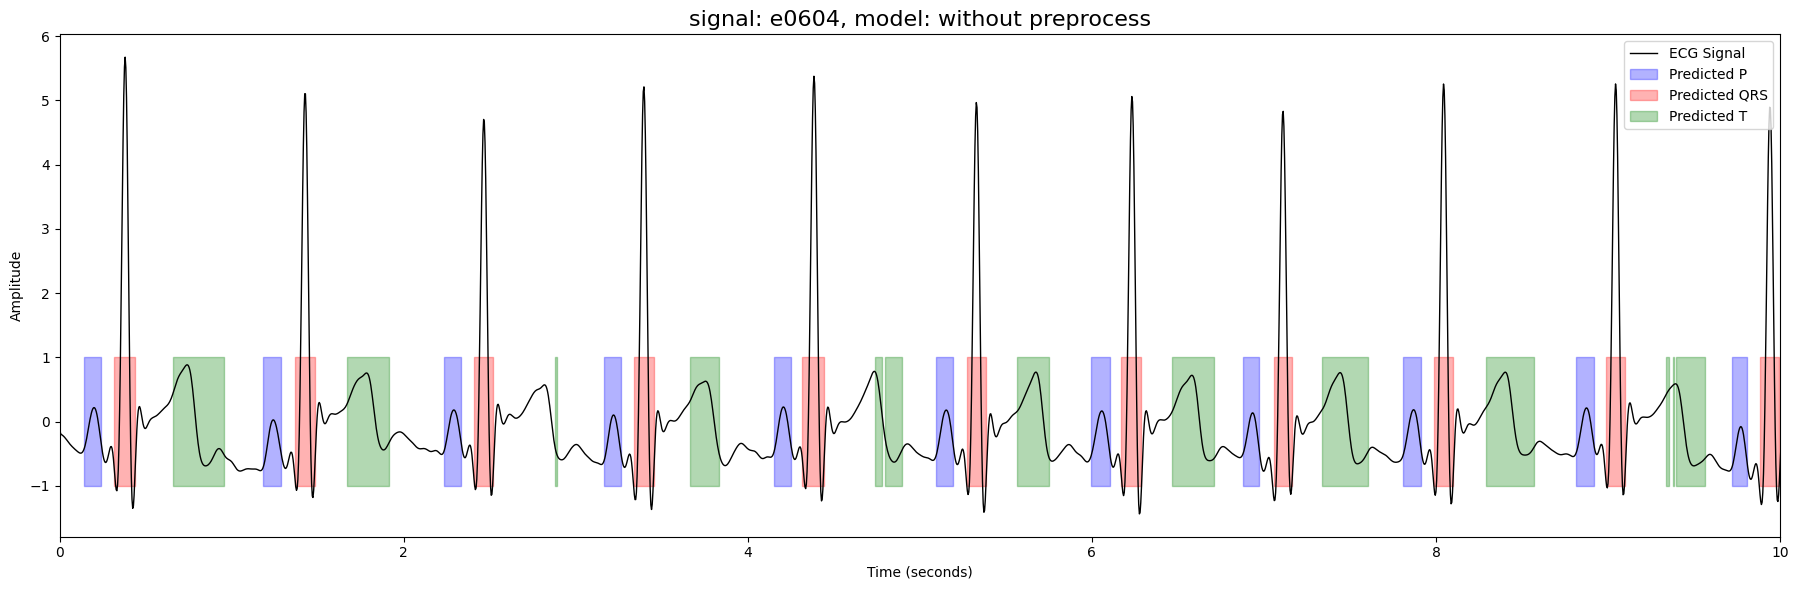

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------


Processing QRS: 100%|██████████| 15/15 [00:00<00:00, 5534.84it/s]


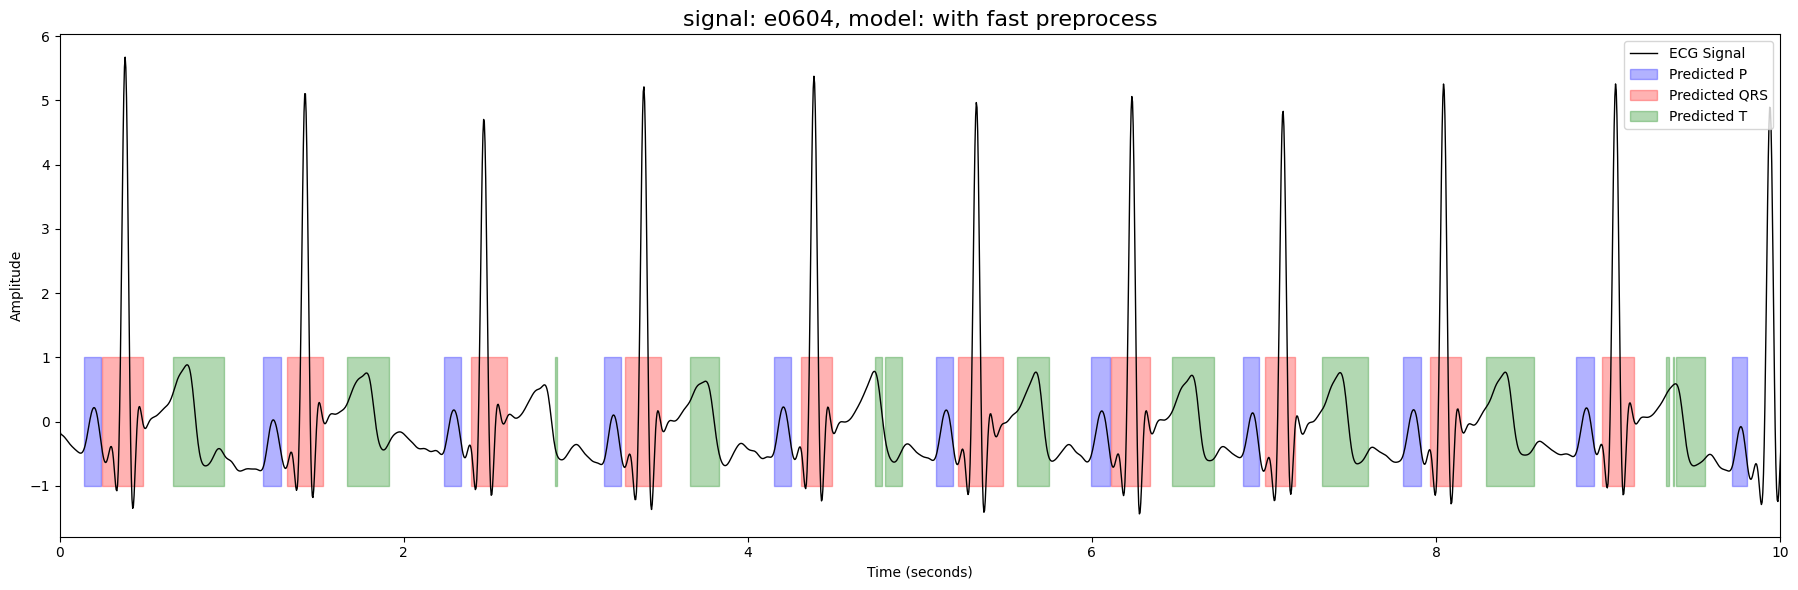

In [24]:
base_path = '/kaggle/input/qtdb-ludb/physionet.org/files/mitdb/1.0.0/'
rd_name = '115'
record_name = base_path+rd_name

record = wfdb.rdrecord(record_name)
signal = record.p_signal[:, 0]
fs = record.fs
signal = signal[int(10*fs):int(25*fs)]
mask,segments,_ = predict_full_ecg(signal, model_deep, fs=fs)
signal = np.concatenate(segments, axis=2)
signal = signal.reshape(-1)
boundaries_fast = get_wave_boundaries(mask)
visualize_boundaries(signal, boundaries_fast,signal_name="e0604", model_name="without preprocess", fs=250, zoom=(0, 10))

print(120*"-")
print(120*"-")

mask = fast_fix_QRS(signal,mask)
boundaries_fast = get_wave_boundaries(mask)
visualize_boundaries(signal, boundaries_fast,signal_name="e0604", model_name="with fast preprocess", fs=250, zoom=(0, 10))

# Full Post processing 

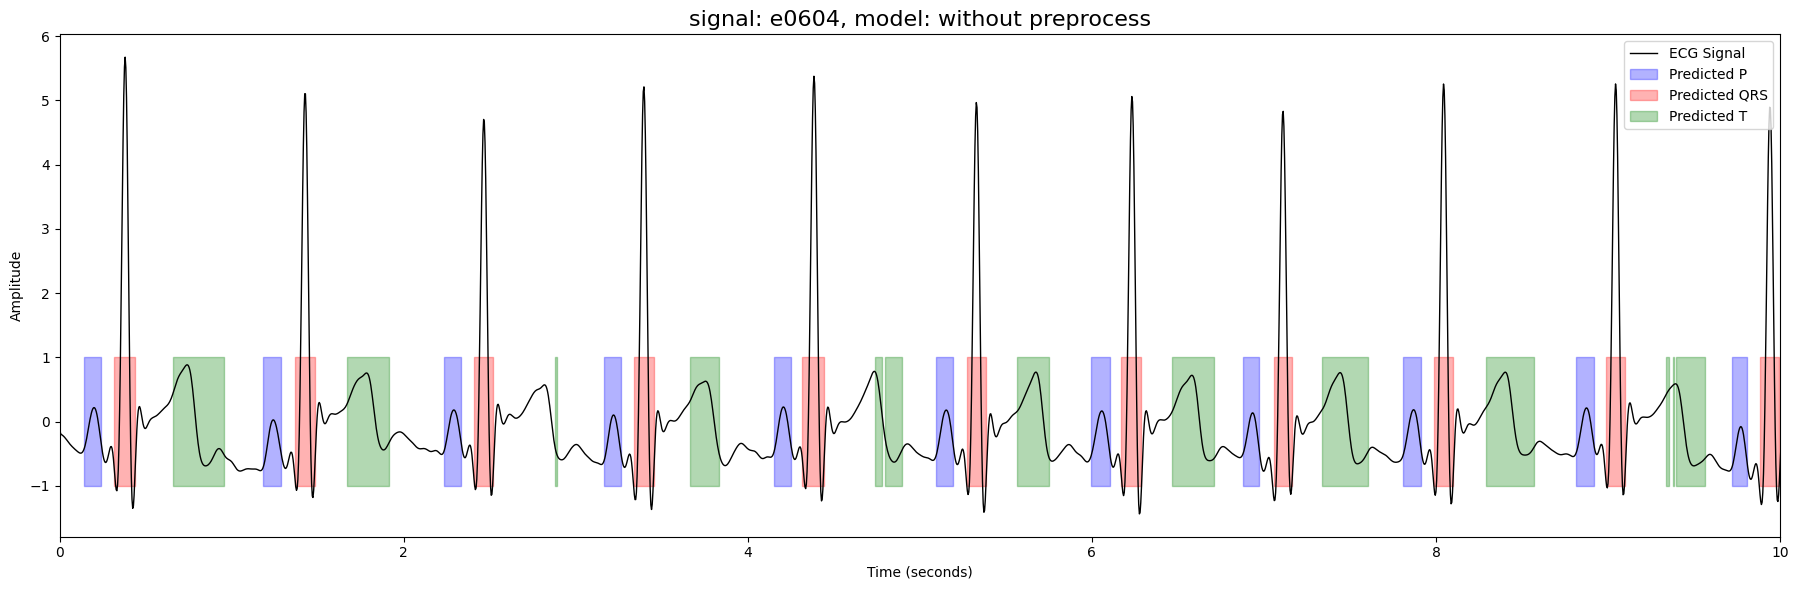

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------


Processing QRS: 100%|██████████| 15/15 [00:00<00:00, 8475.62it/s]


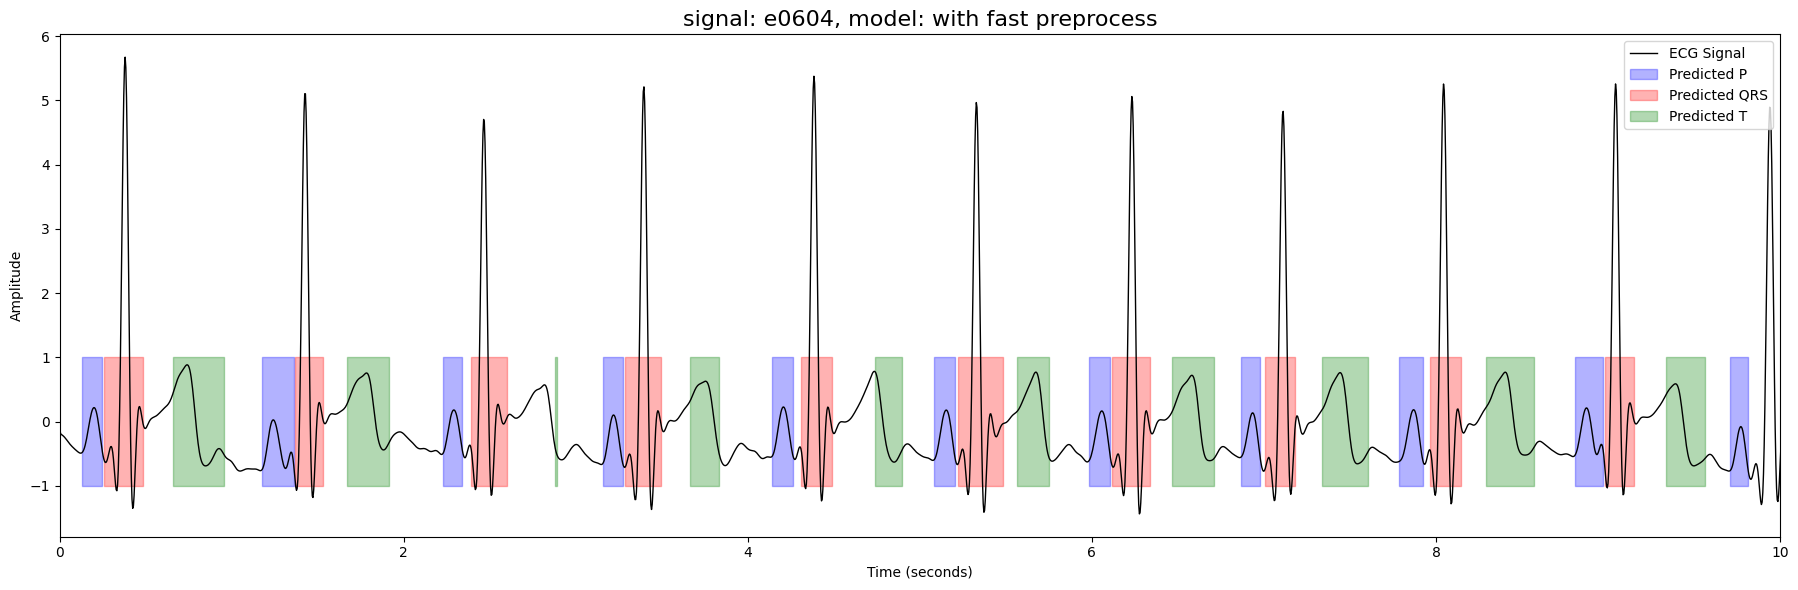

In [25]:
base_path = '/kaggle/input/qtdb-ludb/physionet.org/files/mitdb/1.0.0/'
rd_name = '115'
record_name = base_path+rd_name

record = wfdb.rdrecord(record_name)
signal = record.p_signal[:, 0]
fs = record.fs
signal = signal[int(10*fs):int(25*fs)]
mask,segments,_ = predict_full_ecg(signal, model_deep, fs=fs)
signal = np.concatenate(segments, axis=2)
signal = signal.reshape(-1)
boundaries_fast = get_wave_boundaries(mask)
visualize_boundaries(signal, boundaries_fast,signal_name="e0604", model_name="without preprocess", fs=250, zoom=(0, 10))

print(120*"-")
print(120*"-")

# Post-process mask
mask = remove_uncomplete_first_last_wave(mask)
mask = merge_close_waves(mask)
mask = remove_irrelevant_waves(mask)
mask = check_repeated_waves(mask)
mask = fix_P(signal, mask)
mask = fast_fix_QRS(signal, mask, fs=250)
mask = merge_close_waves(mask)
boundaries_fast = get_wave_boundaries(mask)
visualize_boundaries(signal, boundaries_fast,signal_name="e0604", model_name="with fast preprocess", fs=250, zoom=(0, 10))